In [7]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score

%matplotlib inline
pd.set_option('display.max_columns', 100)

In [8]:
def one_hot(lst, num_class=4) :
    return np.eye(num_class)[lst]

In [9]:
def making_data(csv) :
    activity = pd.read_csv(csv).drop("Unnamed: 0", axis=1)
    label = activity[["acc_id", "label"]]
    
    activity = activity[activity["label"] != "empty"]
    activity = activity.drop("label", axis=1)
    label = label[label["label"] != "empty"]
    
    activity = activity.sort_values(["acc_id","wk"])[['acc_id', 'wk', 'cnt_clear_bam', 'cnt_clear_inzone_light','cnt_clear_inzone_normal', 
                                                  'cnt_clear_inzone_skilled', 'cnt_clear_inzone_solo', 'cnt_clear_raid', 'cnt_clear_raid_light',
                                                  'cnt_dt', 'cnt_enter_bam', 'cnt_enter_inzone_light', 'cnt_enter_inzone_normal', 
                                                  'cnt_enter_inzone_skilled', 'cnt_enter_inzone_solo', 'cnt_enter_raid', 'cnt_enter_raid_light',
                                                  'cnt_use_buffitem', 'district_chat', 'duel_cnt', 'duel_win', 'faction_chat', 'game_combat_time', 
                                                  'gathering_cnt', 'get_money','guild_chat', 'item_hongmun', 'making_cnt', 'normal_chat', 
                                                  'npc_exp', 'npc_hongmun', 'party_chat', 'partybattle_cnt', 'partybattle_win', 'play_time', 
                                                  'quest_exp', 'quest_hongmun', 'whisper_chat','first_week', 'payment_amount']]
    label = label.sort_values("acc_id")
    
    label_lst = sorted(list(set([tuple(x) for x in label.values])))
    label = pd.DataFrame(label_lst, columns = ["acc_id", "label"])
    
    activity1 = activity[activity["wk"]==1].drop(["acc_id", "wk"], axis=1)
    activity2 = activity[activity["wk"]==2].drop(["acc_id", "wk"], axis=1)
    activity3 = activity[activity["wk"]==3].drop(["acc_id", "wk"], axis=1)
    activity4 = activity[activity["wk"]==4].drop(["acc_id", "wk"], axis=1)
    activity5 = activity[activity["wk"]==5].drop(["acc_id", "wk"], axis=1)
    activity6 = activity[activity["wk"]==6].drop(["acc_id", "wk"], axis=1)
    activity7 = activity[activity["wk"]==7].drop(["acc_id", "wk"], axis=1)
    activity8 = activity[activity["wk"]==8].drop(["acc_id", "wk"], axis=1)
    
    num_values = len(activity1.values[0])
    
    activity = np.concatenate([activity1.values.reshape([-1, 1, num_values]), activity2.values.reshape([-1, 1, num_values]), 
                               activity3.values.reshape([-1, 1, num_values]), activity4.values.reshape([-1, 1, num_values]),
                               activity5.values.reshape([-1, 1, num_values]), activity6.values.reshape([-1, 1, num_values]),
                               activity7.values.reshape([-1, 1, num_values]), activity8.values.reshape([-1, 1, num_values])], axis=1)
    
    label_dic = {"week":0 , "month" :1, "2month":2, "retained":3}

    label2 = label.sort_values(by="acc_id")
    label2["label"] = label2["label"].map(lambda x : label_dic[x])
    
    total_lst = activity
    label_dic = label2.label.tolist()
    total_label = one_hot(label_dic)
    
    return total_lst, total_label

 <br></br><br></br><br></br>

In [10]:
total_lst, total_label = making_data("OnlyExpanded.csv")

In [11]:
idx1 = len(total_lst)//5 *4

training_lst = np.array(total_lst[:idx1])
valid_lst = np.array(total_lst[idx1:])

training_label = np.array(total_label[:idx1])
valid_label = np.array(total_label[idx1:])

In [12]:
print(np.array(total_lst).shape)
print(np.array(total_label).shape)

(100000, 8, 38)
(100000, 4)


<br></br><br></br><br></br>

# Model

In [21]:
class CNN() :
    def __init__(self, sess, name):
        self.sess = sess
        self.name = name
        
    def convolution(self, input_X, kernel_size, width, num_filter, activation=True) :
        conv = tf.layers.conv2d(input_X, filters=num_filter, kernel_size=[kernel_size, width], strides=1)
        
        if activation :
            norm = tf.contrib.layers.layer_norm(conv)
            relu = tf.nn.relu(norm)
        
            return relu
        return conv
        
    def build(self, batch_size, height, width, depth, is_embedding, emb_width, num_filter, is_fc, fc_num_unit, fc_activation, cost_function, output_dim) :
        with tf.variable_scope(self.name) :
            
            ## Setting ##
            self.batch_size = batch_size
            self.height = height
            self.width = width
            self.depth = depth
            self.is_embedding = is_embedding
            self.emb_width = emb_width
            self.num_filter = num_filter
            self.is_fc = is_fc
            self.fc_num_unit = fc_num_unit
            self.fc_activation = fc_activation
            self.output_dim = output_dim
            
            self.X = tf.placeholder(tf.float32, [None, self.height, self.width])
            self.Y = tf.placeholder(tf.float32, [None, self.output_dim])
            self.learning_rate =  tf.placeholder(tf.float32)
            self.training = tf.placeholder(tf.bool)
            #############
            
            
            ## Embedding ##
            if self.is_embedding :
                W_emb = tf.Variable(tf.random_normal([self.width, self.emb_width]))
                self.X = tf.concat(self.X, tf.matmul(self.X, W_emb), axis=2)
                
            reshaped_X = tf.reshape(self.X, [-1, self.height, self.width, self.depth])
            ###############
            
            
            ## Convolution ##
            conv1 = self.convolution(reshaped_X, 1, self.width, self.num_filter)
            conv1 = self.convolution(conv1, 3, 1, self.num_filter*2)
            conv1 = self.convolution(conv1, 3, 1, self.num_filter*4)
            conv1 = self.convolution(conv1, 1, 1, self.num_filter, activation=False)
            conv1 = self.convolution(conv1, 3, 1, self.num_filter*2)
            conv1 = self.convolution(conv1, 2, 1, self.num_filter*4)
            conv1 = self.convolution(conv1, 1, 1, self.num_filter//4, activation=False)
            batch, height, width, depth = conv1.get_shape().as_list()
            conv1 = tf.reshape(conv1, [-1, height*width*depth])
            
            
            conv2 = self.convolution(reshaped_X, 2, self.width, self.num_filter)
            conv2 = self.convolution(conv2, 3, 1, self.num_filter*2)
            conv2 = self.convolution(conv2, 3, 1, self.num_filter*4)
            conv2 = self.convolution(conv2, 1, 1, self.num_filter, activation=False)
            conv2 = self.convolution(conv2, 3, 1, self.num_filter*2)
            conv2 = self.convolution(conv2, 1, 1, self.num_filter//4, activation=False)
            batch, height, width, depth = conv2.get_shape().as_list()
            conv2 = tf.reshape(conv2, [-1, height*width*depth])
            
            
            conv3 = self.convolution(reshaped_X, 3, self.width, self.num_filter)
            conv3 = self.convolution(conv3, 3, 1, self.num_filter*2)
            conv3 = self.convolution(conv3, 3, 1, self.num_filter*4)
            conv3 = self.convolution(conv3, 1, 1, self.num_filter, activation=False)
            conv3 = self.convolution(conv3, 2, 1, self.num_filter*2)
            conv3 = self.convolution(conv3, 1, 1, self.num_filter//4, activation=False)
            batch, height, width, depth = conv3.get_shape().as_list()
            conv3 = tf.reshape(conv3, [-1, height*width*depth])
            
            
            conv4 = self.convolution(reshaped_X, 4, self.width, self.num_filter)
            conv4 = self.convolution(conv4, 3, 1, self.num_filter*2)
            conv4 = self.convolution(conv4, 3, 1, self.num_filter*4)
            conv4 = self.convolution(conv4, 1, 1, self.num_filter//4, activation=False)
            batch, height, width, depth = conv4.get_shape().as_list()
            conv4 = tf.reshape(conv4, [-1, height*width*depth])
            
            
            conv5 = self.convolution(reshaped_X, 5, self.width, self.num_filter)
            conv5 = self.convolution(conv5, 3, 1, self.num_filter*2)
            conv5 = self.convolution(conv5, 2, 1, self.num_filter*4)
            conv5 = self.convolution(conv5, 1, 1, self.num_filter//4, activation=False)
            batch, height, width, depth = conv5.get_shape().as_list()
            conv5 = tf.reshape(conv5, [-1, height*width*depth])
            
            
            conv6 = self.convolution(reshaped_X, 6, self.width, self.num_filter)
            conv6 = self.convolution(conv6, 3, 1, self.num_filter*2)
            conv6 = self.convolution(conv6, 1, 1, self.num_filter//4, activation=False)
            batch, height, width, depth = conv6.get_shape().as_list()
            conv6 = tf.reshape(conv6, [-1, height*width*depth])
            
            
            conv7 = self.convolution(reshaped_X, 7, self.width, self.num_filter)
            conv7 = self.convolution(conv7, 2, 1, self.num_filter*2)
            conv7 = self.convolution(conv7, 1, 1, self.num_filter//4, activation=False)
            batch, height, width, depth = conv7.get_shape().as_list()
            conv7 = tf.reshape(conv7, [-1, height*width*depth])
            
            
            conv8 = self.convolution(reshaped_X, 8, self.width, self.num_filter)
            conv8 = self.convolution(conv8, 1, 1, self.num_filter*2)
            conv8 = self.convolution(conv8, 1, 1, self.num_filter//8, activation=False)
            batch, height, width, depth = conv8.get_shape().as_list()
            conv8 = tf.reshape(conv8, [-1, height*width*depth])
            #################
            
            ## Classifier ##
            conv_result = tf.concat([conv1, conv2, conv3, conv4, conv5, conv6, conv7, conv8], axis=1)
            
            if is_fc : 
                dense= tf.layers.dense(conv_result, self.fc_num_unit)
                norm = tf.contrib.layers.layer_norm(dense)
                relu = tf.nn.relu(norm)
                self.logit = tf.layers.dense(norm, 4)
            else :
                self.logit = tf.layers.dense(conv_result, 4)
                
            self.softmax = tf.nn.softmax(self.logit)
            ################
            
            
            ## Learning ##
            if cost_function == "f1" :
                self.numerator = tf.reduce_sum(self.softmax*self.Y)
                self.denominator = tf.reduce_sum(self.softmax*self.Y + self.Y)
                self.cost = -2 * self.numerator / self.denominator
                
            else :
                self.cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=self.logit, labels=self.Y))

            update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS, scope=self.name)
            with tf.control_dependencies(update_ops):
                self.optimizer = tf.train.AdamOptimizer(learning_rate=self.learning_rate).minimize(self.cost)
            
            self.prediction = tf.equal(tf.argmax(self.logit, 1), tf.argmax(self.Y, 1))     
            self.accuracy = tf.reduce_mean(tf.cast(self.prediction, tf.float32))    
            ##############
        
        
    def train(self, X_input, Y_input, learning_rate, training=True):
        feed_dict = {self.X: X_input, self.Y: Y_input, self.learning_rate: learning_rate, self.training: training}
        _, cost = self.sess.run([self.optimizer, self.cost], feed_dict=feed_dict)
        
        return _, cost
    
    def predict(self, X_input, training=False):
        feed_dict = {self.X: X_input, self.training: training}
        result = self.sess.run([self.logit], feed_dict=feed_dict)
            
        return result
    
    def evaluate(self, X_input, Y_input):
        size = X_input.shape[0]
            
        total_loss = 0
        total_acc = 0
            
        for idx in range(0, size, self.batch_size):
            X_batch = X_input[idx:idx + batch_size]
            Y_batch = Y_input[idx:idx + batch_size]
            feed_dict = {self.X: X_batch, self.Y: Y_batch, self.training: False}
                
            loss = self.cost
            accuracy = self.accuracy
                
            step_loss, step_acc = self.sess.run([loss, accuracy], feed_dict=feed_dict)
                
            total_loss += step_loss * X_batch.shape[0]
            total_acc += step_acc * X_batch.shape[0]
            
        total_loss /= size
        total_acc /= size
            
        return total_loss, total_acc

In [29]:
tf.reset_default_graph() 

<br></br><br></br><br></br> 

In [30]:
learning_rate1 = 0.02
learning_rate2 = 0.01
learning_rate3 = 0.005
learning_rate4 = 0.001

total_epoch = 80
batch_size = 500
input_dim = np.array(total_lst).shape[1]

In [31]:
idx = 0
is_pass = False
model_lst = []

for is_embedding in [False, True] :
    for emb_width in [64,128] :
        if not is_pass :
            is_pass = True
            continue
            
        for num_filter in [16, 32] :
            for is_fc in [False, True] :
                for cost in ["accuracy"] :
                    print(idx) 
                    sess = tf.Session()
                    model = CNN(sess, "model{}".format(idx))
                    model.build(500, 8, 38, 1, False, emb_width, num_filter, is_fc, 128, tf.nn.relu, cost, 4)
                    sess.run(tf.global_variables_initializer())

                    model_lst.append(model)
                    idx +=1
            
tl_ta_vl_va_lst = [[[],[],[],[]]]*len(model_lst)
print("Ready!")

0
1
2
3
4
5
6
7
8
9
10
11
Ready!


In [32]:
print('Learning Started!')
print("")

# train my model
for epoch in range(total_epoch):
    avg_cost = [0]*len(model_lst)
    total_batch = int(len(training_lst) / batch_size)
    idx = 0
    
    if epoch == 0 :
        learning_rate = learning_rate1
    elif epoch == 10 :
        learning_rate = learning_rate2
    elif epoch == 20 :
        learning_rate = learning_rate3
    elif epoch == 80 :
        learning_rate = learning_rate4

    for i in range(total_batch):
        batch_xs, batch_ys = training_lst[idx:idx+batch_size],training_label[idx:idx+batch_size]
        
        for model_num, model in enumerate(model_lst) :
            _, c = model.train(batch_xs, batch_ys, learning_rate)
            avg_cost[model_num] += c / total_batch
        
        idx += batch_size
        if i%10 == 0 :
            print("log :", i)
            
    #train/valid cost & acc
    print("***epoch*** : ", epoch)
    for model_num, model in enumerate(model_lst) :
        train_cost, train_acc = model.evaluate(training_lst, training_label)
        valid_cost, valid_acc = model.evaluate(valid_lst, valid_label)

        tl_ta_vl_va_lst[model_num][0].append(train_cost)
        tl_ta_vl_va_lst[model_num][1].append(train_acc)
        tl_ta_vl_va_lst[model_num][2].append(valid_cost)
        tl_ta_vl_va_lst[model_num][3].append(valid_acc)

        print("-- train {:.5f}({:.1f}%), valid{:.5f}({:.1f}%)".format(train_cost, train_acc*100, valid_cost, valid_acc*100))
    
    for model in model_lst :
        print('Accuracy:', model.evaluate(valid_lst, valid_label)[1])
    print(" ")

print("")
print('Learning Finished!')

Learning Started!

log : 0
log : 10
log : 20
log : 30
log : 40
log : 50
log : 60
log : 70
log : 80
log : 90
log : 100
log : 110
log : 120
log : 130
log : 140
log : 150
***epoch*** :  0
-- train 0.86454(62.6%), valid0.85876(62.7%)
-- train 0.90079(59.9%), valid0.89450(59.7%)
-- train 0.87524(60.9%), valid0.86959(61.3%)
-- train 0.91289(60.4%), valid0.90614(60.8%)
-- train 0.87001(61.4%), valid0.86751(62.0%)
-- train 0.89514(61.8%), valid0.89174(61.8%)
-- train 0.91848(60.1%), valid0.91210(60.5%)
-- train 0.90227(60.7%), valid0.89724(60.8%)
-- train 0.86437(62.4%), valid0.86128(62.4%)
-- train 0.90767(60.0%), valid0.90260(60.3%)
-- train 0.86549(61.7%), valid0.85991(62.0%)
-- train 0.88578(61.0%), valid0.87956(61.2%)
Accuracy: 0.6265000030398369
Accuracy: 0.5971500009298325
Accuracy: 0.6134999990463257
Accuracy: 0.6079999968409538
Accuracy: 0.6204500019550323
Accuracy: 0.6178999960422515
Accuracy: 0.6045999959111213
Accuracy: 0.6084000021219254
Accuracy: 0.6241500049829483
Accuracy: 0.60

Accuracy: 0.6788000017404556
Accuracy: 0.668649996817112
Accuracy: 0.668099993467331
Accuracy: 0.6710500016808509
Accuracy: 0.6719499975442886
Accuracy: 0.6704499989748001
Accuracy: 0.6757999986410141
Accuracy: 0.6753499984741211
 
log : 0
log : 10
log : 20
log : 30
log : 40
log : 50
log : 60
log : 70
log : 80
log : 90
log : 100
log : 110
log : 120
log : 130
log : 140
log : 150
***epoch*** :  8
-- train 0.71665(68.5%), valid0.74190(67.9%)
-- train 0.73133(67.6%), valid0.75214(66.9%)
-- train 0.72545(68.3%), valid0.74325(67.8%)
-- train 0.71674(68.3%), valid0.73486(67.5%)
-- train 0.71330(68.4%), valid0.73588(67.7%)
-- train 0.72814(67.9%), valid0.74748(67.3%)
-- train 0.72273(67.8%), valid0.74530(67.3%)
-- train 0.73388(66.9%), valid0.75534(66.1%)
-- train 0.72751(68.3%), valid0.74662(67.5%)
-- train 0.72351(68.1%), valid0.74530(67.6%)
-- train 0.72636(67.0%), valid0.74469(66.4%)
-- train 0.71976(68.6%), valid0.74119(67.7%)
Accuracy: 0.6792499989271163
Accuracy: 0.6691999986767769
Accu

-- train 0.68182(69.7%), valid0.72475(68.5%)
-- train 0.68307(69.6%), valid0.72711(68.3%)
-- train 0.69119(69.4%), valid0.73429(68.4%)
Accuracy: 0.6839500024914742
Accuracy: 0.6841999992728234
Accuracy: 0.6858999982476235
Accuracy: 0.6845000043511391
Accuracy: 0.6886500000953675
Accuracy: 0.6838000014424324
Accuracy: 0.6849999964237213
Accuracy: 0.6845499992370605
Accuracy: 0.6816500008106232
Accuracy: 0.6851499989628792
Accuracy: 0.6831499993801117
Accuracy: 0.6839500024914742
 
log : 0
log : 10
log : 20
log : 30
log : 40
log : 50
log : 60
log : 70
log : 80
log : 90
log : 100
log : 110
log : 120
log : 130
log : 140
log : 150
***epoch*** :  16
-- train 0.68076(69.6%), valid0.73089(68.3%)
-- train 0.68768(69.3%), valid0.73216(68.1%)
-- train 0.68112(70.0%), valid0.73886(68.5%)
-- train 0.67644(70.0%), valid0.72350(68.6%)
-- train 0.66597(70.0%), valid0.72098(68.6%)
-- train 0.68162(69.6%), valid0.72328(68.4%)
-- train 0.66916(70.3%), valid0.72038(68.8%)
-- train 0.67260(70.2%), valid0.7

-- train 0.64336(70.6%), valid0.73109(68.1%)
-- train 0.65911(70.5%), valid0.72815(68.6%)
-- train 0.64138(71.4%), valid0.73126(68.8%)
-- train 0.64039(71.4%), valid0.74243(68.8%)
-- train 0.65895(70.9%), valid0.72812(68.8%)
-- train 0.65057(70.6%), valid0.72690(68.6%)
-- train 0.64905(70.2%), valid0.74245(67.9%)
-- train 0.65028(70.8%), valid0.73743(68.8%)
Accuracy: 0.687349995970726
Accuracy: 0.6843499973416328
Accuracy: 0.6784999966621399
Accuracy: 0.6903999969363213
Accuracy: 0.6806000009179115
Accuracy: 0.6862499937415123
Accuracy: 0.6880499988794326
Accuracy: 0.6882499948143959
Accuracy: 0.688400000333786
Accuracy: 0.6864999979734421
Accuracy: 0.6790500029921531
Accuracy: 0.688199995458126
 
log : 0
log : 10
log : 20
log : 30
log : 40
log : 50
log : 60
log : 70
log : 80
log : 90
log : 100
log : 110
log : 120
log : 130
log : 140
log : 150
***epoch*** :  24
-- train 0.65133(70.7%), valid0.72846(68.5%)
-- train 0.66133(70.2%), valid0.75125(68.4%)
-- train 0.64720(70.5%), valid0.7527

log : 110
log : 120
log : 130
log : 140
log : 150
***epoch*** :  31
-- train 0.63890(71.3%), valid0.74005(68.4%)
-- train 0.64666(70.7%), valid0.76603(68.3%)
-- train 0.62896(71.3%), valid0.77908(67.9%)
-- train 0.61853(72.3%), valid0.75348(69.0%)
-- train 0.62338(71.5%), valid0.75310(67.9%)
-- train 0.64008(71.3%), valid0.74506(68.9%)
-- train 0.62027(72.0%), valid0.75545(68.9%)
-- train 0.61394(72.5%), valid0.77019(69.3%)
-- train 0.64838(71.0%), valid0.73780(69.0%)
-- train 0.64164(71.2%), valid0.75372(68.8%)
-- train 0.62495(71.7%), valid0.76440(68.4%)
-- train 0.63545(71.4%), valid0.75022(68.6%)
Accuracy: 0.6844499975442886
Accuracy: 0.6832999989390374
Accuracy: 0.6788999944925308
Accuracy: 0.6902999967336655
Accuracy: 0.6790999963879585
Accuracy: 0.6888999998569488
Accuracy: 0.6891000002622605
Accuracy: 0.6934999972581863
Accuracy: 0.6901000007987023
Accuracy: 0.6877000018954277
Accuracy: 0.6843999996781349
Accuracy: 0.6864999979734421
 
log : 0
log : 10
log : 20
log : 30
log : 4

Accuracy: 0.6903499960899353
Accuracy: 0.6885000005364418
Accuracy: 0.6881000012159347
Accuracy: 0.6868000000715255
Accuracy: 0.6901999950408936
 
log : 0
log : 10
log : 20
log : 30
log : 40
log : 50
log : 60
log : 70
log : 80
log : 90
log : 100
log : 110
log : 120
log : 130
log : 140
log : 150
***epoch*** :  39
-- train 0.62750(72.0%), valid0.75090(68.8%)
-- train 0.63186(71.4%), valid0.79100(68.3%)
-- train 0.61209(72.4%), valid0.82433(68.3%)
-- train 0.60340(72.7%), valid0.80448(68.9%)
-- train 0.60359(72.4%), valid0.78146(68.3%)
-- train 0.63076(71.7%), valid0.76526(68.7%)
-- train 0.60283(72.8%), valid0.79846(68.6%)
-- train 0.59967(73.0%), valid0.80375(69.2%)
-- train 0.64149(71.3%), valid0.74875(68.9%)
-- train 0.62530(72.0%), valid0.76662(68.8%)
-- train 0.61028(72.3%), valid0.81473(68.7%)
-- train 0.61728(71.9%), valid0.76912(69.0%)
Accuracy: 0.6876500025391579
Accuracy: 0.6825999960303306
Accuracy: 0.6830999985337257
Accuracy: 0.6892999976873397
Accuracy: 0.6826499983668327
A

-- train 0.60840(72.4%), valid0.79125(69.0%)
Accuracy: 0.6894500002264976
Accuracy: 0.6839499995112419
Accuracy: 0.6828500032424927
Accuracy: 0.6900999948382378
Accuracy: 0.6844499960541726
Accuracy: 0.6834499970078468
Accuracy: 0.6883499950170517
Accuracy: 0.6894499942660332
Accuracy: 0.6879999965429306
Accuracy: 0.6866999968886376
Accuracy: 0.6816999971866607
Accuracy: 0.6901499986648559
 
log : 0
log : 10
log : 20
log : 30
log : 40
log : 50
log : 60
log : 70
log : 80
log : 90
log : 100
log : 110
log : 120
log : 130
log : 140
log : 150
***epoch*** :  47
-- train 0.61510(72.4%), valid0.76615(68.9%)
-- train 0.61811(71.9%), valid0.80772(68.5%)
-- train 0.59594(73.0%), valid0.86991(68.4%)
-- train 0.58179(73.8%), valid0.82328(69.2%)
-- train 0.58442(73.5%), valid0.80897(68.7%)
-- train 0.61745(72.2%), valid0.77629(68.9%)
-- train 0.58061(73.8%), valid0.82853(68.9%)
-- train 0.58523(73.5%), valid0.86065(68.7%)
-- train 0.63055(71.7%), valid0.76258(68.7%)
-- train 0.61536(72.3%), valid0.8

-- train 0.57592(73.8%), valid0.89253(68.5%)
-- train 0.56896(74.4%), valid0.90226(69.1%)
-- train 0.62863(71.8%), valid0.78145(68.6%)
-- train 0.60601(72.7%), valid0.82534(68.6%)
-- train 0.59074(73.1%), valid0.92548(68.7%)
-- train 0.59345(73.0%), valid0.82109(68.8%)
Accuracy: 0.6893499985337257
Accuracy: 0.68125
Accuracy: 0.6788999974727631
Accuracy: 0.6892499998211861
Accuracy: 0.6863999977707863
Accuracy: 0.6876999989151955
Accuracy: 0.6848999992012977
Accuracy: 0.6908499956130981
Accuracy: 0.6862499997019768
Accuracy: 0.6862500011920929
Accuracy: 0.6866499975323677
Accuracy: 0.6876499935984611
 
log : 0
log : 10
log : 20
log : 30
log : 40
log : 50
log : 60
log : 70
log : 80
log : 90
log : 100
log : 110
log : 120
log : 130
log : 140
log : 150
***epoch*** :  55
-- train 0.60526(72.8%), valid0.78387(69.0%)
-- train 0.61036(72.5%), valid0.84821(68.3%)
-- train 0.58670(72.6%), valid0.91579(67.1%)
-- train 0.57823(73.9%), valid0.90361(68.9%)
-- train 0.57930(73.7%), valid0.85010(68.5%)

KeyboardInterrupt: 

 <br></br><br></br><br></br> 

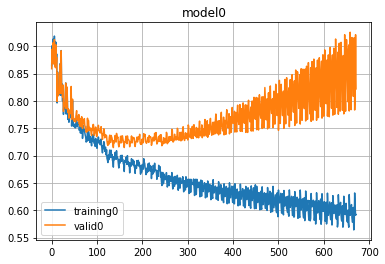

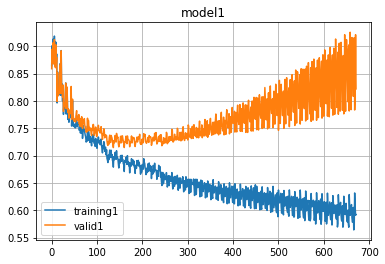

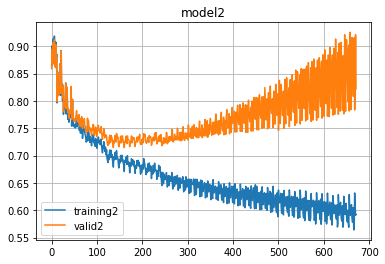

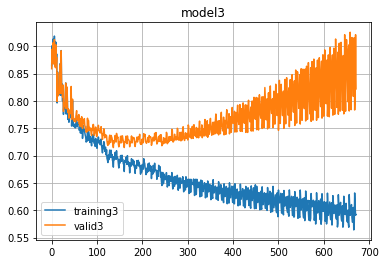

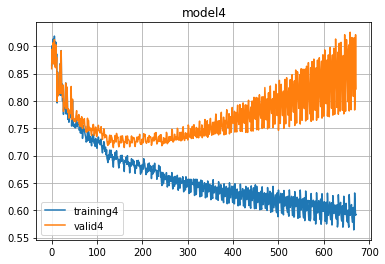

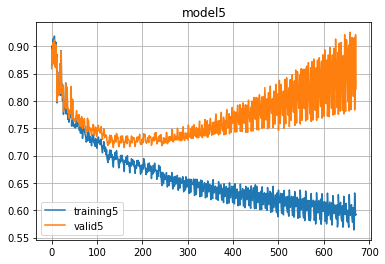

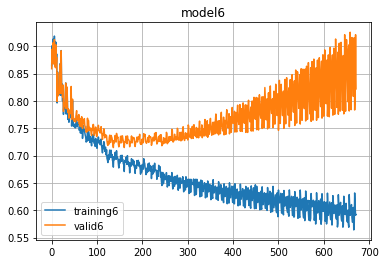

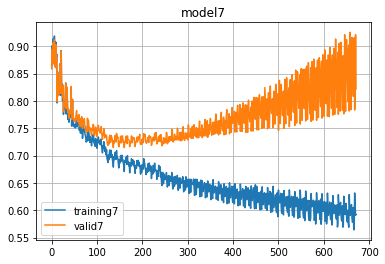

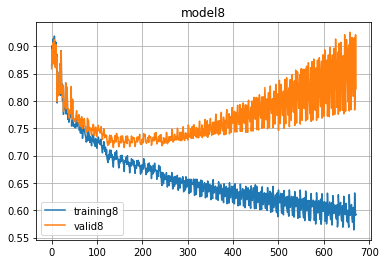

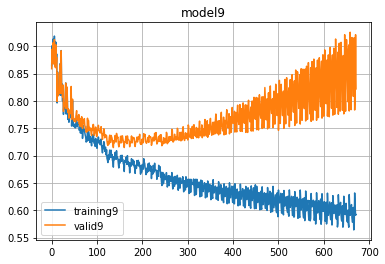

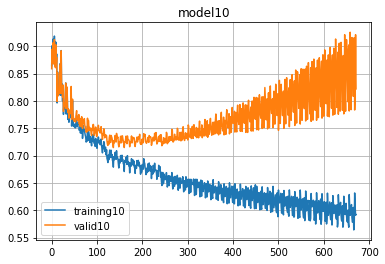

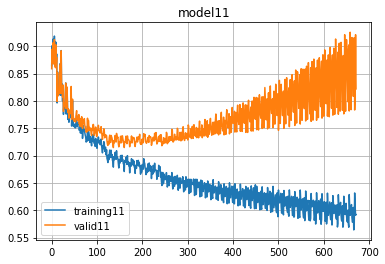

In [33]:
for idx in range(len(model_lst)) :
    plt.plot(tl_ta_vl_va_lst[idx][0], label='training'+str(idx))
    plt.plot(tl_ta_vl_va_lst[idx][2], label='valid'+str(idx))
    plt.title("model"+str(idx))
    plt.grid("on")
    plt.legend()
    plt.show()

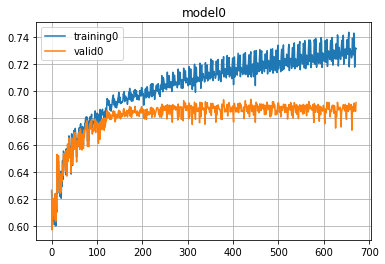

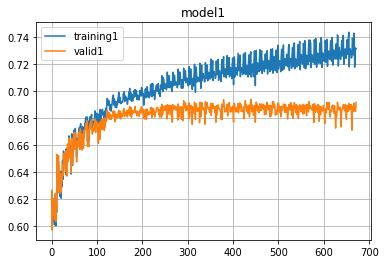

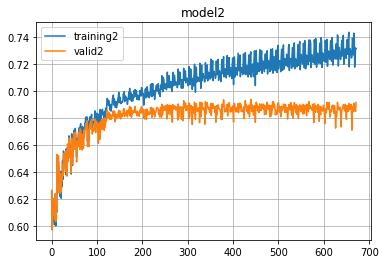

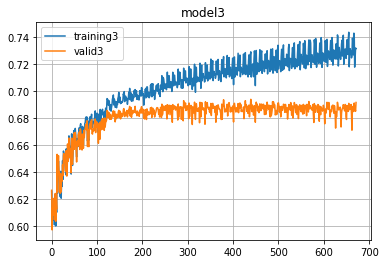

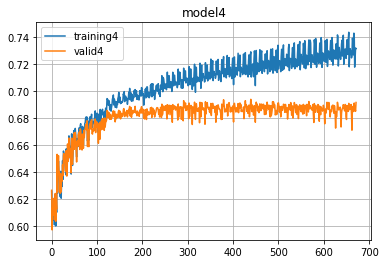

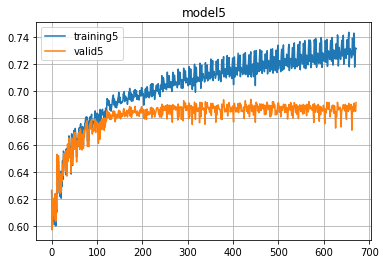

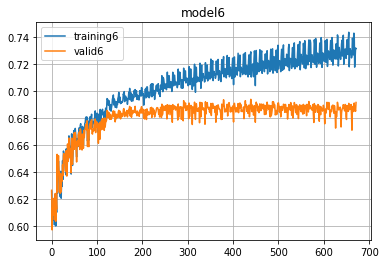

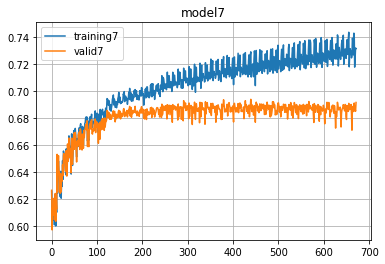

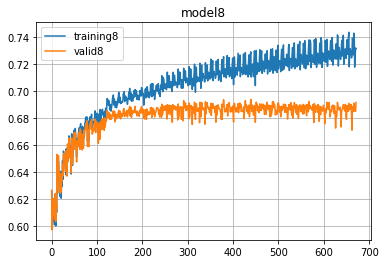

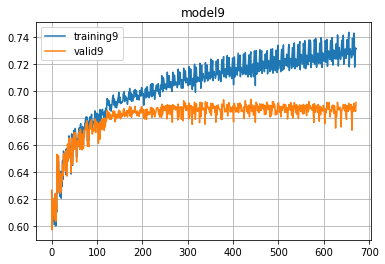

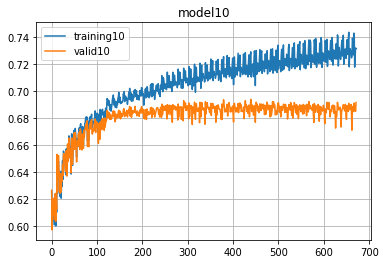

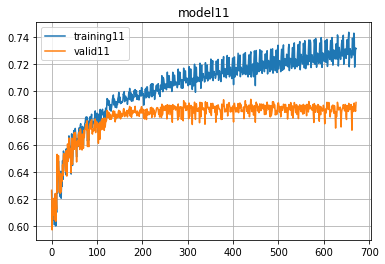

In [34]:
for idx in range(len(model_lst)) :
    plt.plot(tl_ta_vl_va_lst[idx][1], label='training'+str(idx))
    plt.plot(tl_ta_vl_va_lst[idx][3], label='valid'+str(idx))
    plt.title("model"+str(idx))
    plt.grid("on")
    plt.legend()
    plt.show()

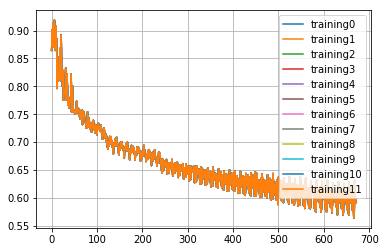

In [35]:
for idx in range(len(model_lst)) :
    plt.plot(tl_ta_vl_va_lst[idx][0], label='training'+str(idx))
    
plt.grid("on")
plt.legend()
plt.show()

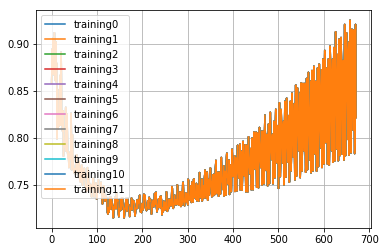

In [36]:
for idx in range(len(model_lst)) :
    plt.plot(tl_ta_vl_va_lst[idx][2], label='training'+str(idx))
    
plt.grid("on")
plt.legend()
plt.show()

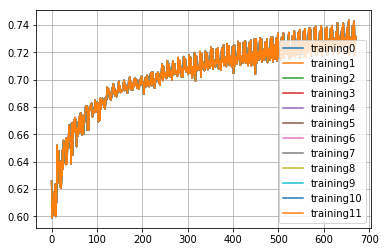

In [37]:
for idx in range(len(model_lst)) :
    plt.plot(tl_ta_vl_va_lst[idx][1], label='training'+str(idx))
    
plt.grid("on")
plt.legend()
plt.show()

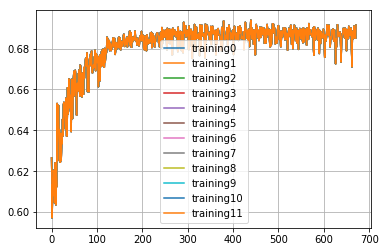

In [38]:
for idx in range(len(model_lst)) :
    plt.plot(tl_ta_vl_va_lst[idx][3], label='training'+str(idx))
    
plt.grid("on")
plt.legend()
plt.show()

 <br></br><br></br><br></br>  

In [ ]:
#tf.reset_default_graph() 

In [364]:
saver = tf.train.Saver()

for idx, model in enumerate(model_lst) :
    saver.save(model.sess, './model/MLP_default_model_{}'.format(idx))

print("Saved!")

'./advanced_RNN/original_user_vector/original'

<br></br><br></br><br></br>

# Test

In [43]:
def making_data(csv) :
    activity = pd.read_csv(csv).drop("Unnamed: 0", axis=1)
    
    activity = activity[activity["label"] == "empty"]
    activity = activity.drop("label", axis=1)
    
    activity = activity.sort_values(["acc_id","wk"])[['acc_id', 'wk', 'cnt_clear_bam', 'cnt_clear_inzone_light','cnt_clear_inzone_normal', 
                                                  'cnt_clear_inzone_skilled', 'cnt_clear_inzone_solo', 'cnt_clear_raid', 'cnt_clear_raid_light',
                                                  'cnt_dt', 'cnt_enter_bam', 'cnt_enter_inzone_light', 'cnt_enter_inzone_normal', 
                                                  'cnt_enter_inzone_skilled', 'cnt_enter_inzone_solo', 'cnt_enter_raid', 'cnt_enter_raid_light',
                                                  'cnt_use_buffitem', 'district_chat', 'duel_cnt', 'duel_win', 'faction_chat', 'game_combat_time', 
                                                  'gathering_cnt', 'get_money','guild_chat', 'item_hongmun', 'making_cnt', 'normal_chat', 
                                                  'npc_exp', 'npc_hongmun', 'party_chat', 'partybattle_cnt', 'partybattle_win', 'play_time', 
                                                  'quest_exp', 'quest_hongmun', 'whisper_chat','first_week', 'payment_amount']]
    
    activity1 = activity[activity["wk"]==1].drop(["acc_id", "wk"], axis=1)
    activity2 = activity[activity["wk"]==2].drop(["acc_id", "wk"], axis=1)
    activity3 = activity[activity["wk"]==3].drop(["acc_id", "wk"], axis=1)
    activity4 = activity[activity["wk"]==4].drop(["acc_id", "wk"], axis=1)
    activity5 = activity[activity["wk"]==5].drop(["acc_id", "wk"], axis=1)
    activity6 = activity[activity["wk"]==6].drop(["acc_id", "wk"], axis=1)
    activity7 = activity[activity["wk"]==7].drop(["acc_id", "wk"], axis=1)
    activity8 = activity[activity["wk"]==8].drop(["acc_id", "wk"], axis=1)
    
    label = activity["acc_id"].values
    num_values = len(activity1.values[0])
    
    activity = np.concatenate([activity1.values.reshape([-1, 1, num_values]), activity2.values.reshape([-1, 1, num_values]), 
                               activity3.values.reshape([-1, 1, num_values]), activity4.values.reshape([-1, 1, num_values]),
                               activity5.values.reshape([-1, 1, num_values]), activity6.values.reshape([-1, 1, num_values]),
                               activity7.values.reshape([-1, 1, num_values]), activity8.values.reshape([-1, 1, num_values])], axis=1)

    total_lst = activity
    return total_lst, label

In [44]:
test_data, test_acc_id = making_data("OnlyExpanded.csv")

In [45]:
print(test_data.shape)

(40000, 8, 38)


<br></br><br></br><br></br> 

# Predict

In [46]:
result = []
for model in model_lst :
    result.append(np.argmax(model.predict(test_data), axis=2)) 
    
result = list(map(lambda x : x.tolist()[0], result))
for r_lst in result :
    print("week: {}, month: {}, 2month: {}, retained: {}".format(r_lst.count(0), r_lst.count(1), r_lst.count(2), r_lst.count(3)))

week: 11450, month: 5978, 2month: 12465, retained: 10107
week: 11421, month: 5384, 2month: 13925, retained: 9270
week: 11381, month: 5849, 2month: 13280, retained: 9490
week: 11562, month: 9689, 2month: 9795, retained: 8954
week: 11298, month: 6401, 2month: 13084, retained: 9217
week: 11577, month: 5284, 2month: 13148, retained: 9991
week: 11183, month: 7283, 2month: 12634, retained: 8900
week: 11810, month: 6271, 2month: 13128, retained: 8791
week: 11361, month: 10802, 2month: 8515, retained: 9322
week: 11779, month: 6180, 2month: 12075, retained: 9966
week: 11449, month: 6553, 2month: 12851, retained: 9147
week: 11184, month: 9412, 2month: 10057, retained: 9347


In [ ]:
label_df = pd.DataFrame(sorted(list(set(list(test_acc_id))))).rename(columns = {0 : "acc_id"})
result_df = pd.DataFrame(result).T

In [ ]:
result_df2 = pd.concat([label_df, result_df], axis=1)
result_df2.head()